In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In this post, we study a simple meta learning technique called Stacking

#### Create a noisy dataset using a 3rd degree polynomial


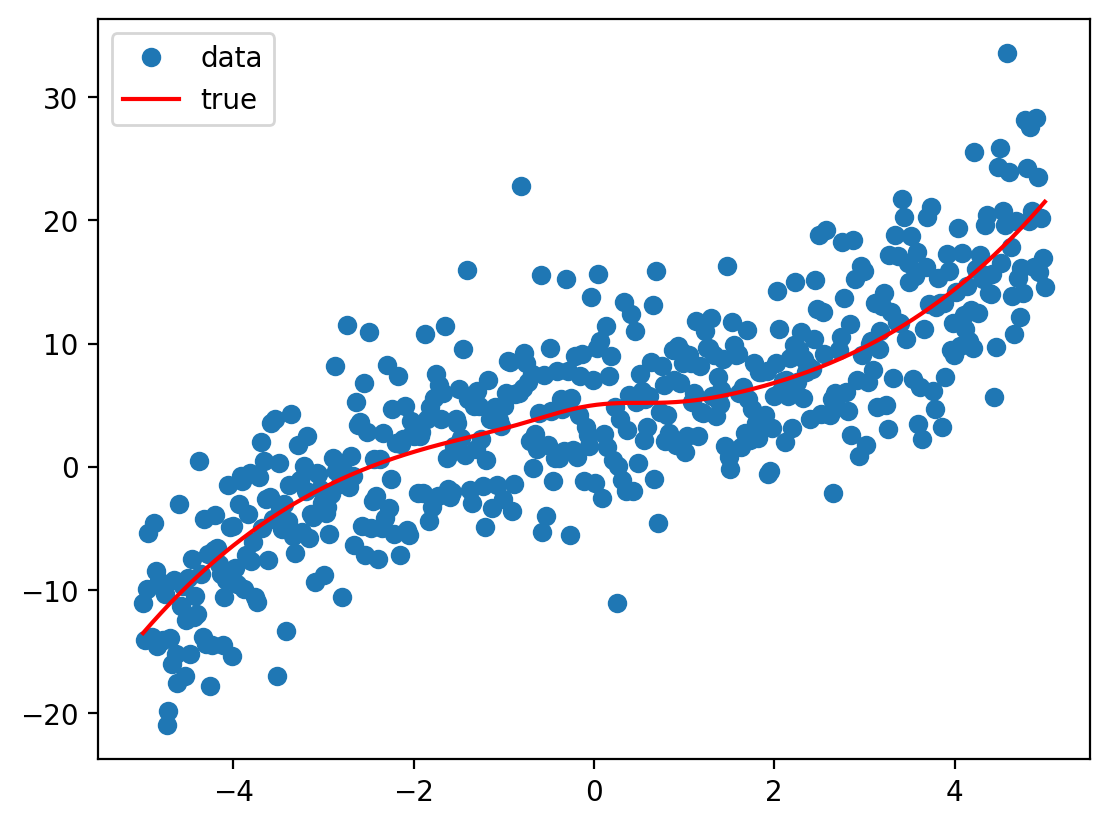

In [90]:
np.random.seed(42)
x = np.linspace(-5, 5, 500)
f = lambda x: 0.1*x**3 + 0.2**x**2 + x + 4
y = f(x) + 0.05*np.random.normal(0, 100, 500)

plt.plot(x, y, 'o', label = 'data')
plt.plot(x, f(x), 'r', label = 'true')
plt.legend()

### Create a train, validation and test set and plot them

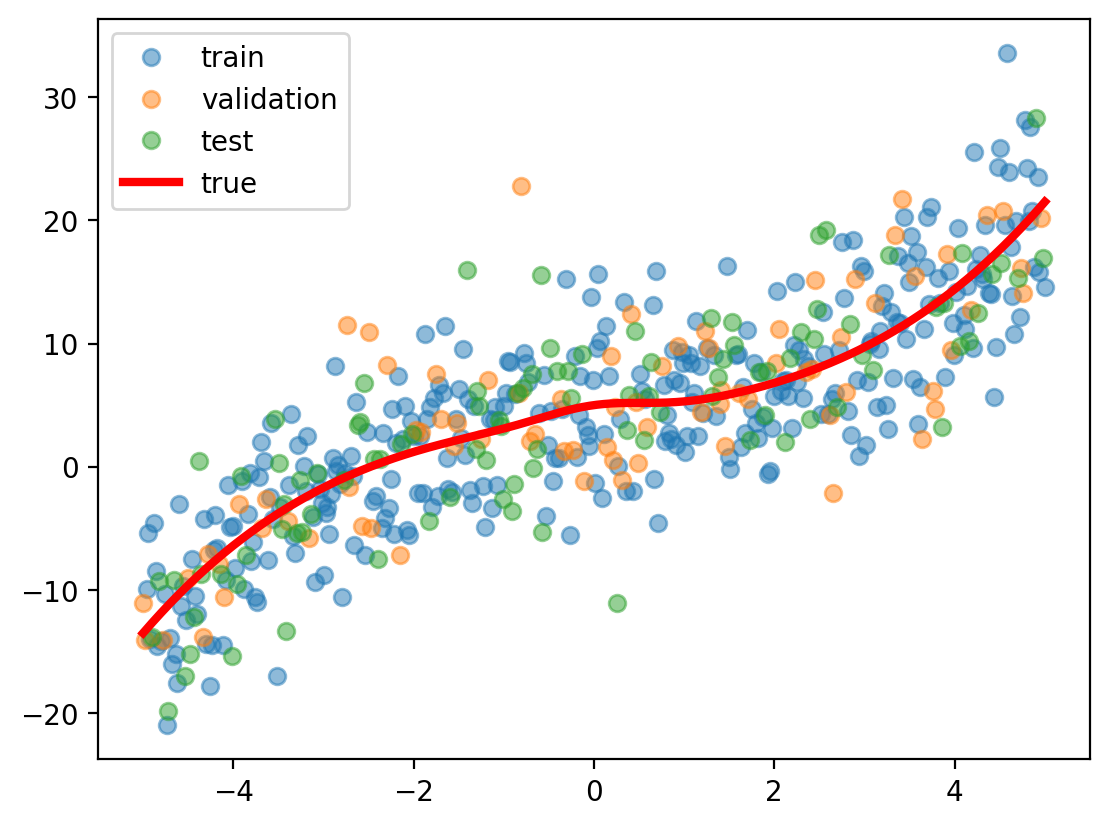

In [126]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

plt.plot(x_train, y_train, 'o', label = 'train', alpha = 0.5)
plt.plot(x_val, y_val, 'o', label = 'validation', alpha = 0.5)
plt.plot(x_test, y_test, 'o', label = 'test', alpha = 0.5)
plt.plot(x, f(x), 'r', label = 'true', lw=3)
plt.legend()


### First layer of models

In [116]:

# Create a pipeline for linear regression using a polynomial feature transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

lr = Pipeline([('poly', PolynomialFeatures(degree=4)),
                ('linear', LinearRegression(fit_intercept=True))])

# Fit the model
lr.fit(x_train.reshape(-1, 1), y_train)


dt = DecisionTreeRegressor(max_depth=3)
_ = dt.fit(x_train.reshape(-1, 1), y_train)

### Plot fits on 1d grid

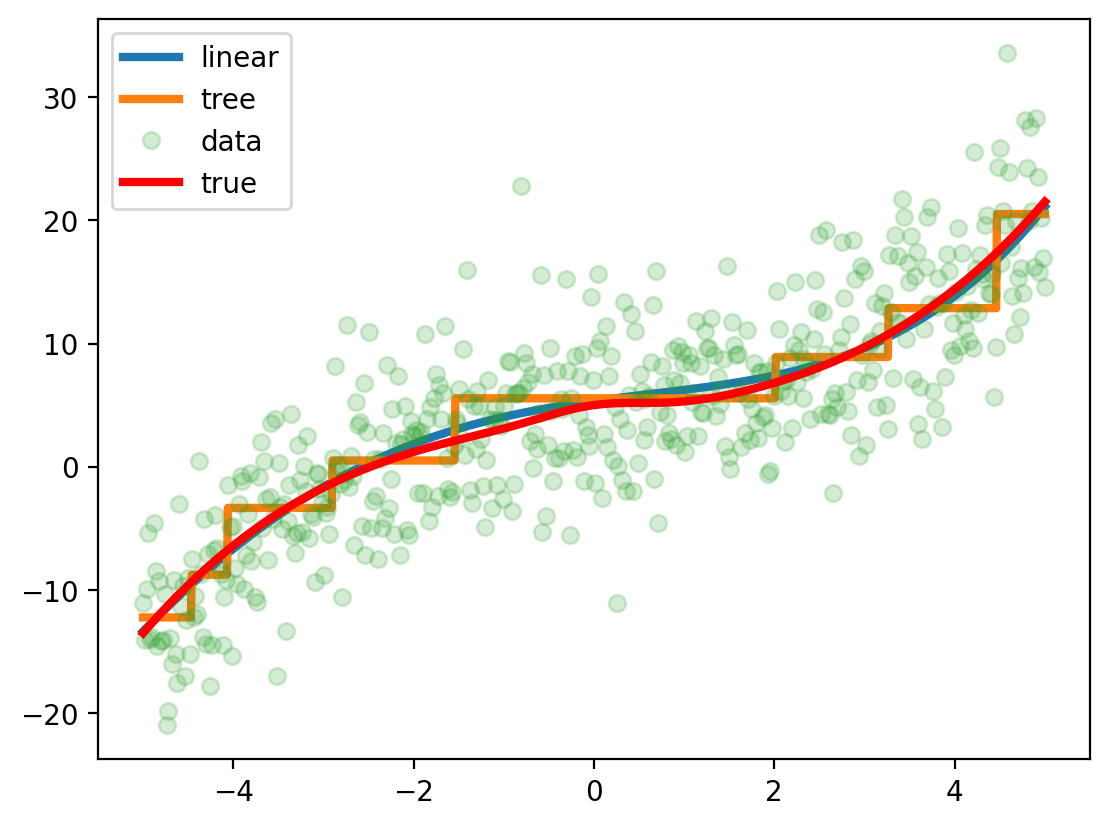

In [127]:
x_grid = np.linspace(-5, 5, 1000)
plt.plot(x_grid, lr.predict(x_grid.reshape(-1, 1)), label='linear', lw=3)
plt.plot(x_grid, dt.predict(x_grid.reshape(-1, 1)), label='tree', lw=3)
plt.plot(x, y, 'o', label='data', alpha=0.2)
plt.plot(x, f(x), 'r', label='true', lw=3)
plt.legend()

In [118]:
# Train and test errors using sklearn.metrics.mean_squared_error
from sklearn.metrics import mean_squared_error

print('Train error linear: ', mean_squared_error(y_train, lr.predict(x_train.reshape(-1, 1))))
print('Test error linear: ', mean_squared_error(y_test, lr.predict(x_test.reshape(-1, 1))))
print('Train error tree: ', mean_squared_error(y_train, dt.predict(x_train.reshape(-1, 1))))
print('Test error tree: ', mean_squared_error(y_test, dt.predict(x_test.reshape(-1, 1))))

Train error linear:  23.46788157726629
Test error linear:  27.134650046478445
Train error tree:  21.815913230319516
Test error tree:  27.93779675241768


### Second layer of models trained on the predictions of the first layer on the validation set


In [122]:

# Create a new dataset with the predictions of the first layer
x_val_lr = lr.predict(x_val.reshape(-1, 1))
x_val_dt = dt.predict(x_val.reshape(-1, 1))
x_val_2d = np.column_stack((x_val_lr, x_val_dt))

# Fit a linear regression model on the new dataset
lr2 = LinearRegression()
lr2.fit(x_val_2d, y_val)


LinearRegression()

In [124]:
# Errors on the test set

# Feature set for the test set
x_test_lr = lr.predict(x_test.reshape(-1, 1))
x_test_dt = dt.predict(x_test.reshape(-1, 1))
x_test_2d = np.column_stack((x_test_lr, x_test_dt))

# Test error
print('Test error META: ', mean_squared_error(y_test, lr2.predict(x_test_2d)))
print('Test error linear: ', mean_squared_error(y_test, lr.predict(x_test.reshape(-1, 1))))
print('Test error tree: ', mean_squared_error(y_test, dt.predict(x_test.reshape(-1, 1))))


Test error META:  28.452960162875993
Test error linear:  27.134650046478445
Test error tree:  27.93779675241768


### Include the raw features in the second layer


In [125]:

# Feature set for the test set
x_test_3d = np.column_stack((x_test_lr, x_test_dt, x_test))

# Fit a linear regression model on the new dataset
lr3 = LinearRegression()
lr3.fit(x_test_3d, y_test)


# Test error
print('Test error Meta (with original features): ', mean_squared_error(y_test, lr3.predict(x_test_3d)))
print('Test error linear: ', mean_squared_error(y_test, lr.predict(x_test.reshape(-1, 1))))
print('Test error tree: ', mean_squared_error(y_test, dt.predict(x_test.reshape(-1, 1))))

Test error Meta (with original features):  24.834946677497967
Test error linear:  27.134650046478445
Test error tree:  27.93779675241768


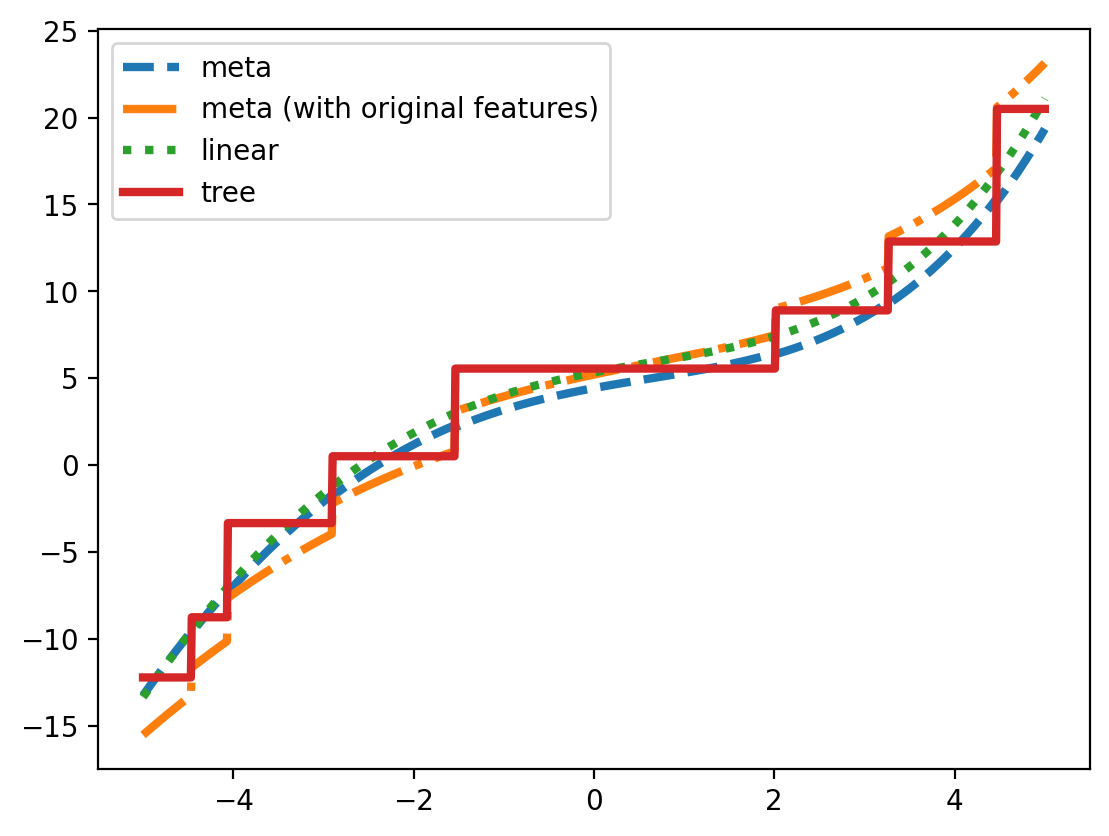

In [137]:
# Plot the fits on the 1d grid
x_grid_lr = lr.predict(x_grid.reshape(-1, 1))
x_grid_dt = dt.predict(x_grid.reshape(-1, 1))
x_grid_2d = np.column_stack((x_grid_lr, x_grid_dt))
x_grid_3d = np.column_stack((x_grid_lr, x_grid_dt, x_grid))

plt.plot(x_grid, lr2.predict(x_grid_2d), label='meta', lw=3, linestyle='--')
plt.plot(x_grid, lr3.predict(x_grid_3d), label='meta (with original features)', lw=3, linestyle='-.')
plt.plot(x_grid, lr.predict(x_grid.reshape(-1, 1)), label='linear', lw=3, ls=':')
plt.plot(x_grid, dt.predict(x_grid.reshape(-1, 1)), label='tree', lw=3, ls='-')
#plt.plot(x, y, 'o', label='data', alpha=0.2)
#plt.plot(x, f(x), 'r', label='true', lw=3)
plt.legend()